<a href="https://colab.research.google.com/github/einsteinxx/BE223B_UCLA_W2020/blob/master/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

#specific versions required for downloaded code segments
#!pip3 install -q scipy==1.2.0
#!pip3 install -q imgaug==0.2.6


#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
drive.mount('/content/gdrive')

### MAIN DIRECTORY NAMES
gdir =           '/content/gdrive/My Drive/'
main_directory = gdir

#
#directory of top level of user data
#
feature_folder = 'FEATURE_EXTRACTION'
data_dir = os.path.join(gdir,feature_folder,'centroids')
tiles_dir = os.path.join(gdir,feature_folder,'tiles_rois','normalized')
tile_melanomas_dir = os.path.join(gdir,feature_folder,'tile_melanomas_examples')
tile_label_dir = os.path.join(gdir,feature_folder,'tiles_rois')
mask_dir = os.path.join(gdir,'masks')


heat_dir = os.path.join(gdir,feature_folder,'OUTPUTS','HEAT')
sub_red_dir= os.path.join(gdir,feature_folder,'OUTPUTS','SUBPLOTS','SUB_QUAD_RED')
sub_blue_dir= os.path.join(gdir,feature_folder,'OUTPUTS','SUBPLOTS','SUB_QUAD_BLUE')
sub_green_dir= os.path.join(gdir,feature_folder,'OUTPUTS','SUBPLOTS','SUB_QUAD_GREEN')





Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
'''
Load mask data for images
'''
mask_files = os.listdir(mask_dir)

for counter,ii in enumerate(mask_files):
    print(ii)
    if (counter < 1):
        mdata = np.load(os.path.join(mask_dir, ii))
print(np.shape(mdata))

15116_43904_15232.npy
6820_16128_5376.npy
3255_82432_38528.npy
2670_54656_15232.npy
5073_43008_13440.npy
1261_20608_34944.npy
13314_93184_17024.npy
6210_14336_7168.npy
13220_17920_22400.npy
4889_81536_42112.npy
3379_86016_24192.npy
3468_3584_34944.npy
8181_115584_6272.npy
6913_9856_21504.npy
8545_33152_22400.npy
3486_70784_11648.npy
99_88704_21504.npy
1002_2688_38528.npy
3994_13440_5376.npy
3960_25088_18816.npy
3591_16128_17024.npy
15423_63616_17920.npy
7800_38528_34048.npy
8007_90496_2688.npy
1441_84224_14336.npy
15104_129920_25088.npy
9348_93184_44800.npy
10775_28672_20608.npy
11935_7168_26880.npy
13326_6272_12544.npy
11299_17024_28672.npy
8860_86016_13440.npy
11006_56448_8960.npy
3711_84224_17024.npy
6522_124544_19712.npy
2307_23296_24192.npy
6725_65408_30464.npy
4047_20608_14336.npy
6024_100352_21504.npy
12592_17920_34944.npy
7884_62720_19712.npy
15012_24192_41216.npy
5007_60032_6272.npy
66_11648_33152.npy
8025_84224_34048.npy
7664_26880_36736.npy
962_42560_5824.npy
3281_17920_2956

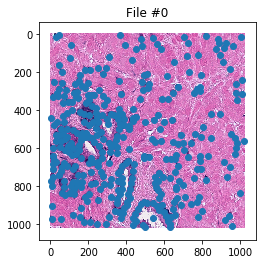

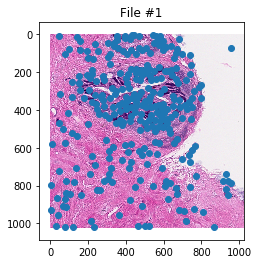

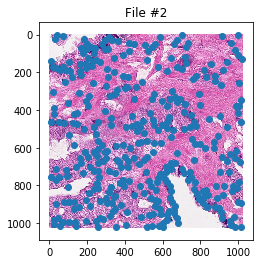

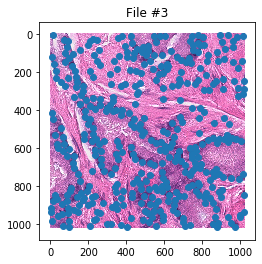

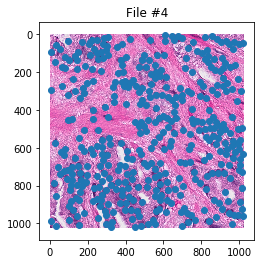

In [4]:
data_files = os.listdir(data_dir)

xdim = 1024 #csv image dimensions to be plotted on
ydim = 1024

file_counter = 0 #inc for each file opened
all_xx ={}
all_yy = {}
for filename in data_files:
#    #open file and grab all csv data
#    file = open(filename,"r") 

    full_filename = os.path.join(data_dir,filename)
    with open(full_filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        xx = [] #init new list to hold all x,y data
        yy = []
        for row in csv_reader:
            if line_count == 0:
                #print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
                #print('row set: ', row)
                xx.append(float(row[0]))
                yy.append(float(row[1]))
                #print('x and y ',row[0],row[1])
                line_count += 1
        #print(f'Processed {line_count} lines.')



        #sf = 1.5 #scale temp image to be a bit bigger than biggest points
        #temp_image = np.zeros((np.int64(np.max(xx)*sf), np.int64(np.max(yy)*sf)))

        #add in the centroid points
        #for ii in range(0,len(xx)):
            #print('ii is ',ii)
            #x = np.round(xx[ii])
            #y = np.round(yy[ii])
            #print('x,y = ',x,y)
            #temp_image[x,y] = 1
    
    # Read Images 



    if (file_counter < 5):
        root_ext = os.path.splitext(filename)
        tile_file = root_ext[0] + '.png'
        tile_roi_file = os.path.join(tiles_dir, tile_file)

        img = Image.open(tile_roi_file)
        img = img.resize((1024, 1024), Image.ANTIALIAS)
        #img.resize((1024,1024))
        #a = np.asarray(img)
        #img = mpimg.imread(tile_roi_file) 
        plt.figure()
        #scaled_tile = np.zeros((1024,1024))
        plt.subplots
        plt.imshow(img)
        plt.scatter(xx, yy)
        plt.title('File #' +str(file_counter))


    #add x,y data to the main dictionaries
    all_xx[file_counter] = xx
    all_yy[file_counter] = yy

    file_counter = file_counter + 1

In [5]:
'''
Get Cancer, No Cancer listing
'''

label_file = os.path.join(tile_label_dir,'dataset.csv')

#header row:
#slidename    title    label 

tile_roi_status={}

with open(label_file) as label_data:
    csv_reader = csv.reader(label_data, delimiter=',')
    line_count = 0

    for row in csv_reader:
        if line_count == 0:
                #print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print('row set: ', row)
            tile_roi_status[row[1]] = row[2]
            #tile_roi_label.append(row[2])

                #print('x and y ',row[0],row[1])
            line_count += 1
        #print(f'Processed {line_count} lines.')


row set:  ['3637', '3637_81536_41216', '1']
row set:  ['6790', '6790_14336_17024', '1']
row set:  ['6427', '6427_44800_8960', '0']
row set:  ['12166', '12166_22400_30464', '0']
row set:  ['3491', '3491_121856_35840', '1']
row set:  ['1302', '1302_10752_24192', '1']
row set:  ['13225', '13225_3584_34944', '0']
row set:  ['7473', '7473_9856_18816', '1']
row set:  ['15123', '15123_90496_18816', '0']
row set:  ['7309', '7309_5376_29568', '0']
row set:  ['1622', '1622_44800_16128', '1']
row set:  ['4366', '4366_41216_8064', '1']
row set:  ['6820', '6820_16128_5376', '1']
row set:  ['10629', '10629_8064_19712', '0']
row set:  ['7802', '7802_20608_29568', '1']
row set:  ['1588', '1588_9856_10752', '1']
row set:  ['6667', '6667_72576_24192', '1']
row set:  ['11974', '11974_76160_19712', '0']
row set:  ['10398', '10398_84224_18816', '0']
row set:  ['8024', '8024_69888_31360', '0']
row set:  ['5404', '5404_78848_32256', '1']
row set:  ['6292', '6292_14336_26880', '1']
row set:  ['3250', '3250_72

## Data is stored from each file, now do stuff with it

In [6]:
## Get the number of nuclei
num_nuclei=[]
for ii in range(0,len(all_xx)):
    num_nuclei.append(len(all_xx[ii]))
    print('Number of nuclei at file# ', ii,num_nuclei[ii])

Number of nuclei at file#  0 363
Number of nuclei at file#  1 285
Number of nuclei at file#  2 348
Number of nuclei at file#  3 400
Number of nuclei at file#  4 399
Number of nuclei at file#  5 197
Number of nuclei at file#  6 299
Number of nuclei at file#  7 400
Number of nuclei at file#  8 108
Number of nuclei at file#  9 262
Number of nuclei at file#  10 400
Number of nuclei at file#  11 353
Number of nuclei at file#  12 282
Number of nuclei at file#  13 366
Number of nuclei at file#  14 400
Number of nuclei at file#  15 333
Number of nuclei at file#  16 309
Number of nuclei at file#  17 347
Number of nuclei at file#  18 386
Number of nuclei at file#  19 159
Number of nuclei at file#  20 298
Number of nuclei at file#  21 328
Number of nuclei at file#  22 400
Number of nuclei at file#  23 400
Number of nuclei at file#  24 308
Number of nuclei at file#  25 268
Number of nuclei at file#  26 284
Number of nuclei at file#  27 272
Number of nuclei at file#  28 400
Number of nuclei at file

1000
number of total points at file  363
number of total points at file  285
number of total points at file  348
number of total points at file  400
number of total points at file  399


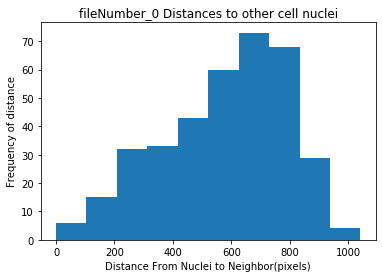

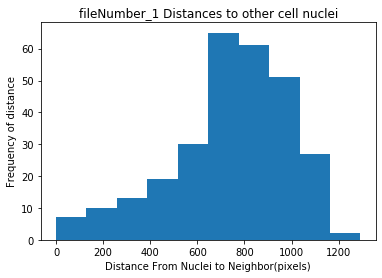

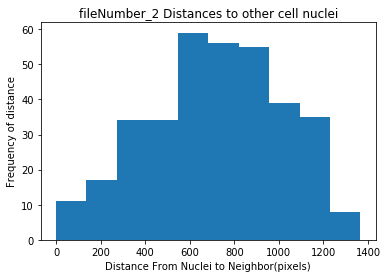

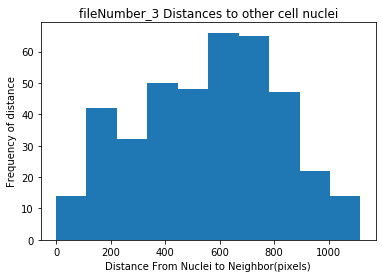

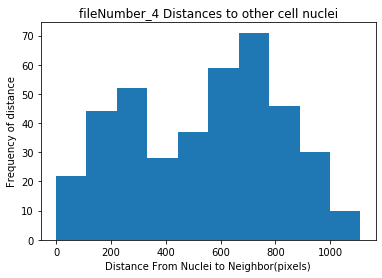

In [7]:
# DISTANCE FROM EACH OTHER
print(len(all_xx))
distance_vals={}
for filenum,cc in enumerate(range(0,len(all_xx))):
    #at the file level, which has many x and y values in a list
    distance_vals[filenum]={} #add list to the dict entry
    for ii in range(0,len(all_xx[filenum])):
        #top level x and y will be what each other point is compared to
        distance_vals[filenum][ii] =[]
        xtop = all_xx[filenum][ii]
        ytop = all_yy[filenum][ii]
        
        for jj in range(0,len(all_xx[filenum])):
            xtest= all_xx[filenum][jj]
            ytest = all_yy[filenum][jj]

            #get xy distance from current to trial
            #dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            dist = math.sqrt((xtop - xtest)**2 + (ytop - ytest)**2)
            distance_vals[filenum][ii].append(dist)


    if (cc < 5):
        print('number of total points at file ',len(distance_vals[cc]))
        plt.figure()
        plt.hist(distance_vals[filenum][ii])
        tname = 'fileNumber_' + str(cc) + ' Distances to other cell nuclei'
        plt.xlabel('Distance From Nuclei to Neighbor(pixels)')
        plt.ylabel('Frequency of distance')
        plt.title(tname)

**Use Networkx to produce a simple neighbor cell plot**

In [8]:
'''
Get node locations in a simpler format
'''
node_pos ={}
for filenum in range(0,len(all_xx)):
    #each key in all_xx is one filenumber
    node_pos[filenum] =[]  #for this key, make a list of all xy pairs
    for ii in range(0,len(all_xx[filenum])):
        node_pos[filenum].append([all_xx[filenum][ii],all_yy[filenum][ii]])

print('shape of node_pos in fn0',np.shape(node_pos[0]))
print('Show first xy pair of first file to verify')
print(node_pos[0][0])

shape of node_pos in fn0 (363, 2)
Show first xy pair of first file to verify
[777.7492163009405, 111.4921630094044]


type of g is  <class 'networkx.classes.graph.Graph'>
size of g node data =  (363,)
size of g edge data =  (990, 2)
fig size in pixels  [720. 720.]


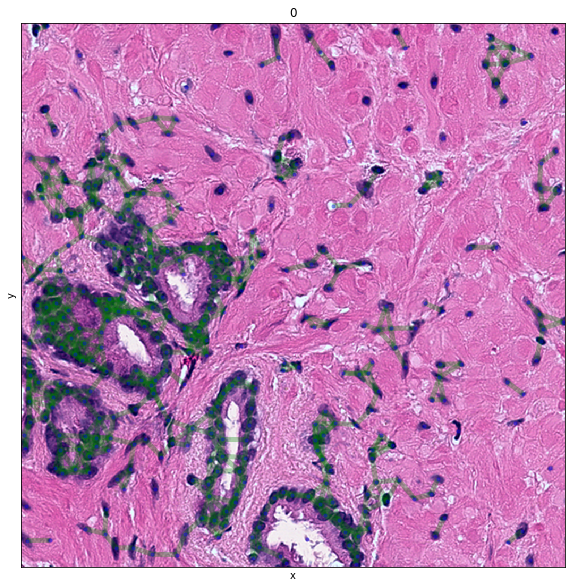

In [82]:



import networkx as nx
g = None
g = nx.Graph()
#g = nx.MultiDiGraph() #directed graph, so they go outward only
plt.figure(figsize=(10, 10)) #larger temporary plots for viewing close nodes

print('type of g is ', type(g))
#nx information for plots
node_size=10
node_color='blue'
node_alpha=0.3
node_text_size=6
edge_color='green'
edge_alpha=0.3
edge_thickness=5
edge_text_pos=0.3
text_font='sans-serif'

#
#distance_vals is [filenum] by #of nodes, with each node having the distance to
#all of its neighbors
#

for filenum,cc in enumerate(range(0,1)): #len(all_xx))):
    for inode in range(0,len(distance_vals[filenum])):

        g.add_node(inode,position = node_pos[filenum][inode]) #add this node from the whole set for this file
        #for every node, there's a list of distances to every other node
        for inode2 in range(0,len(distance_vals[filenum][inode])):
                #g.add_nodes_from((inode, inode +1))
            #xyposition = node_pos[filenum][inode]
            #automatically add node 0 as this loop is the starting node always
            distance = distance_vals[filenum][inode][inode2]
            if (distance < 50):
                #print('fn, distance = ', filenum,distance)
                g.add_edge(inode,
                            inode2,
                            weight = distance)
                            #position = node_pos[filenum][inode2]) 
#(distance_vals[filenum][ii])

print('size of g node data = ', np.shape(g.nodes))
print('size of g edge data = ',np.shape(g.edges))
#print('g.node data ',g.nodes(data=True))
#print('g edge data ',g.edges(data=True))


#pos = nx.spring_layout(g) #random_layout(g) #spring_layout(g)
pos = node_pos[0]


draw_nodes = 1
draw_label = 0
draw_edges = 1
if (draw_nodes == 1):
    nx.draw_networkx_nodes(g,
                           pos,
                           node_size=node_size,
                           alpha=node_alpha,
                           node_color=node_color)
if (draw_edges == 1):
    nx.draw_networkx_edges(g,
                           pos,
                           width=edge_thickness,
                           alpha=edge_alpha,
                           edge_color=edge_color)
if (draw_label == 1):
    nx.draw_networkx_labels(g,
                            pos,
                            font_size=node_text_size,
                            font_family=text_font)

#nx.draw(g,pos) 
plt.title(str(filenum))
plt.xlabel('x')
plt.ylabel('y')
fig = plt.gcf()
size = fig.get_size_inches()*fig.dpi # size in pixels
#plt.show()
print('fig size in pixels ',size)


filename = data_files[0]
root_ext = os.path.splitext(filename)
tile_file = root_ext[0] + '.png'
tile_roi_file = os.path.join(tiles_dir, tile_file)

img = Image.open(tile_roi_file)
img = img.resize((1024, 1024), Image.ANTIALIAS)
plt.imshow(img)
plt.show()
#nx.draw_networkx(g,pos)

A = nx.adjacency_matrix(g) #put in #entries x #entries adj matrix


#plt.figure()
#rows, cols = np.where(A == 1)
#edges = zip(rows.tolist(), cols.tolist())
#mylabels = np.arange(0,363)
#gr = nx.Graph()
#gr.add_edges_from(edges)
#nx.draw(gr, node_size=500, labels=mylabels, with_labels=True)
#plt.show()



In [70]:
print(g[5])
print(g.is_directed(), g.is_multigraph())
gdeg = g.degree()
print(g.edges)


{0: {'weight': 413.3077210286177}, 1: {'weight': 579.4658972995329}, 2: {'weight': 375.53213561632407}, 3: {'weight': 539.9689707577185}, 4: {'weight': 220.31788866091307}, 6: {'weight': 451.44924458365705}, 7: {'weight': 487.2216934259065}, 8: {'weight': 324.3938684936302}, 9: {'weight': 378.3272864115173}, 10: {'weight': 334.84404349065784}, 11: {'weight': 641.1961786137512}, 12: {'weight': 499.4259469318335}, 13: {'weight': 528.8305464627028}, 14: {'weight': 464.2012872395142}, 15: {'weight': 309.0059452692566}, 16: {'weight': 521.2139215269996}, 17: {'weight': 461.6566732877276}, 18: {'weight': 437.4931689667019}, 19: {'weight': 35.31982170265677}, 20: {'weight': 302.5165170659522}, 21: {'weight': 313.0194682863116}, 22: {'weight': 382.6661459178056}, 23: {'weight': 344.097896595729}, 24: {'weight': 694.3934108566765}, 25: {'weight': 563.1508139238524}, 26: {'weight': 465.8827285926404}, 27: {'weight': 162.55409769333406}, 28: {'weight': 577.6967758545518}, 29: {'weight': 386.48228

In [11]:
'''
Plot nodes and get set of smallest distances
'''



#for each file and each xy point, get the 5 closest nodes
imgz = np.zeros((1024,1024))
height_map = {}
for filenum in range(0,len(all_xx)):
    #f = plt.figure()

    height_map[filenum] =[]
    print(len(distance_vals[filenum].keys()))
    for key_entry in distance_vals[filenum].keys():
        #d is the distance from the key point to every other point
        d = distance_vals[filenum][key_entry]
        order = np.argsort(d)
        #print(d[order[0]])
        #lowest 4 with first being original point
        low5 = list(order[0:4])

        #plt.imshow(imgz)
        #plt.plot(all_xx[filenum][int(order[0:1])],all_yy[filenum][int(order[0:1])], 'red', linestyle='-', marker='o') #'go-')
        #plt.plot(all_xx[filenum][order[1]],all_yy[filenum][order[1]],'r.')

        #create heights for distance values for each point. At the position of each
        #predicted cell center, put the closest distance value there.
        #print('order 0,1 is ', order[0],order[1])
        #print('len entry is ',all_xx[filenum][order[1]])
        original_cell = [  all_xx[filenum][order[1]], all_yy[filenum][order[1]] ]
        #print('original cell ',original_cell)
        d[order[1]]
        height_map[filenum].append(d[order[1]]) #.append(uint32(original_cell))






363
285
348
400
399
197
299
400
108
262
400
353
282
366
400
333
309
347
386
159
298
328
400
400
308
268
284
272
400
400
337
174
177
334
343
359
360
222
181
220
265
336
382
244
332
249
245
190
327
120
400
259
218
366
116
215
338
400
187
329
238
372
400
289
349
181
300
336
391
287
252
400
179
365
165
224
400
385
369
353
86
126
308
243
351
239
257
149
330
216
313
339
335
294
240
333
314
268
391
191
296
396
356
291
400
282
191
336
302
318
252
247
166
400
286
284
360
106
299
137
309
123
276
260
283
142
400
400
255
400
346
400
339
391
199
164
254
358
165
234
400
190
283
400
360
394
233
233
306
278
194
195
188
310
355
172
394
277
400
332
293
228
354
336
158
102
178
275
197
366
400
236
380
400
287
213
400
201
400
227
392
169
293
158
231
159
230
400
341
330
308
120
298
399
316
332
386
109
127
296
273
289
241
173
302
212
218
183
211
209
373
103
400
119
400
378
326
135
400
76
277
218
144
400
163
400
395
365
400
169
189
256
167
188
165
312
306
232
351
395
149
192
400
383
277
288
241
128
252
395
72

In [12]:


print(d[order[1]])
print(type(height_map[filenum]))
#height_map[filenum].append(d[order[1]]) 
for filenum in range(0,len(all_xx)):
    imgz = np.zeros((1024,1024))
    for ii in range(0,len(height_map[filenum])):
        imgz[int(all_xx[filenum][ii]),int(all_yy[filenum][ii])] = height_map[filenum][ii]

    plt.figure()
    plt.imshow(imgz,cmap='jet')
    plt.colorbar()

    cplot = 'Heat_Plot_File_' + str(filenum) + '.png'
    sname = os.path.join(heat_dir,cplot)
    plt.savefig(sname, format='png',dpi=300, bbox_inches='tight')
    plt.close()


35.96838306567958
<class 'list'>


ValueError: ignored

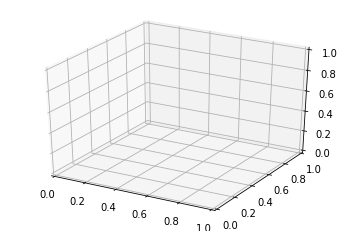

In [13]:
from mpl_toolkits.mplot3d import Axes3D

x = range(1024)
y = range(1024)

fig = plt.figure()
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
dx=5
dy=dx
dz=dy
ax.bar3d(x, y, imgz, dx, dy, dz)
#ax.plot_surface(X, Y, imgz)

#ax.plot_surface(imgz[], edgecolor='none')
ax.set_title('Surface plot')
plt.show()

In [0]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.random.rand(2, 100) * 4
x=all_xx[0]
y = all_yy[0]
print('shape of x and y is ',np.shape(x),np.shape(y))
hist, xedges, yedges = np.histogram2d(x, y, bins=10, range=[[0, 40], [0, 1200]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

In [0]:
#HISTOGRAMS COMPLETED, NOW TRY ??


# import statements
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

new_data = [all_xx[0],all_yy[0]]
# create blobs
data = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)
# create np array for data points
points = data[0]
# create scatter plot
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)



# import KMeans
from sklearn.cluster import KMeans

In [0]:
print(np.shape(data[0]))
print(data[0][0:3,0:3])

# create kmeans object
kmeans = KMeans(n_clusters=4)
#points = (all_xx[0],all_yy[0])
points=np.ndarray((len(all_xx[0]),2))
for ii in range(0,len(all_xx[0])):
    points[ii,0]= all_xx[0][ii]
    points[ii,1] = all_yy[0][ii]

print(np.shape(points[0]))


# fit kmeans object to data
kmeans.fit(points)

# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(points)


#plot returned cluster centers
scaled_tile = np.zeros((1024,1024))
plt.figure()
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])
plt.show()


plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=100, c='red')
plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=100, c='black')
plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=100, c='blue')
plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=100, c='cyan')



plt.figure()
plt.scatter(all_xx[0], all_yy[0])

In [0]:
def get_neighbors(data,xloc,yloc):
    #print('xloc,yloc = ',xloc,yloc)
    #print('shape of data is ',np.shape(data))
    total_n = 0
    for ii in [-1,1]:
        for jj in [-1,1]:
            #print('ii,jj=',ii,jj)
            xp=np.uint(xloc+ii)
            yp = np.uint(yloc + jj)
            #print(xp,yp)
            if (data[xp,yp] > 0):
                total_n = total_n + 1
    return total_n



In [0]:
'''
Get graph points
'''

fnum = 0 #each file 

N={}
i64x=[]
i64y=[]
neighbor_count={}
for ii in range(0,len(all_xx[fnum])):
    print('Running on file ',ii)
    #get neighbors for each node
    i64x=np.uint(all_xx[fnum][ii])
    i64y = np.uint(all_yy[fnum][ii])

    #find neighbor in cross direction
    dxkeys = all_xx.keys()
    for jj in dxkeys:
        #get values for each key
        xvals = all_xx[jj][:]
        yvals = all_yy[jj][:]


        temp_image = np.zeros((1024, 1024))

        #add in the centroid points
        for ii in range(0,len(xvals)):
            #print('ii is ',ii)
            x = np.uint32(np.round(xvals[ii]))
            y = np.uint32(np.round(yvals[ii]))
            #print('x,y = ',x,y)
            temp_image[x,y] = 1


        ncount = 0
        neighbor_count[jj] = np.zeros((1024,1024))
        border = 10
        for kk in range(border,len(xvals)-border):
            for ll in range(border,len(yvals)-border):
                #print('kk,ll = ',kk,ll)
                #print(type(kk))
                x=np.uint32(kk)
                y = np.uint32(ll)
                ncount = 0
                border = 30
                for h in range(-border,border):
                    if (temp_image[x + h,y] >0):
                        ncount = ncount + 1
                    if (temp_image[x - h,y] >0):
                        ncount = ncount + 1 

                for v in range(-border,border):
                    if (temp_image[x,y+v] >0):
                        ncount = ncount + 1
                    if (temp_image[x,y-v] >0):
                        ncount = ncount + 1

                if (ncount > 4):
                    print('more than 4 found')
                #+x
                #if (xvals[kk+1] > 0):
                #    ncount = ncount + 1
                #if (xvals[kk-1] > 0):
                #    ncount = ncount + 1
                #if (yvals[ll+1] > 0):
                #    ncount = ncount + 1
                #if (yvals[ll-1] > 0):
                #    ncount = ncount + 1
            neighbor_count[jj][kk,ll]= neighbor_count[jj][kk,ll] + ncount


print('Completed neighbor check')

In [0]:
import scipy

xvals = all_xx[0][:]
yvals = all_yy[0][:]
print('length of xvals ',len(xvals))
temp_image = np.zeros((1024, 1024))
#add in the centroid points
for ii in range(0,len(xvals)):
    #print('ii is ',ii)
    x = np.uint32(np.ceil(xvals[ii]))
    y = np.uint32(np.ceil(yvals[ii]))
    print('x,y,xval,yval ',x,y, xvals[ii],yvals[ii])
    temp_image[x,y] = np.uint(1)


ind=np.where(temp_image > 0)
print('len index is ',len(ind))
plt.figure()
plt.scatter(all_xx[0],all_yy[0])
plt.title('original')
plt.show()

kernel = np.array([[1,1,1,1,1],[1,1,0,1,1],[1,1,1,1,1]])
neigh_counts = scipy.signal.convolve2d(temp_image,kernel,'full')

plt.figure()
plt.imshow(temp_image[0:5,440:445])
plt.colorbar()
plt.title('Original')
plt.show()

plt.figure()
plt.imshow(neigh_counts)
plt.colorbar()
plt.show()


print('kk is ',type(kk))
plt.figure
plt.imshow(neighbor_count[0][:,:],cmap='jet')
plt.colorbar()

neighbor_count[0]

In [0]:
print(temp_image[43,0])
print(all_xx[0][1:10])

In [0]:
'''
Get clusters of cell centers
'''
#all_xx, yy

#for each center point, see if it has neighbors in surrounding pixels
blank = np.zeros((1024,1024))

ypix =[]
xpix = []
cfile=0
for ii in range(0,len(xdata)):
    xpix.append(np.uint(all_xx[cfile][ii]))
    ypix.append(np.uint(all_yy[cfile][ii]))
    blank[xpix[ii],ypix[ii]] = 1



xdata = all_xx[0]
ydata = all_yy[0]

for ii in range(1,len(xdata)):
    for jj in range(1,len(ydata)):
        current_point = [xdata[ii],ydata[jj]]
        #print('xpix before: ',xpix[ii])
        n = get_neighbors(blank,xpix[ii],ypix[ii])


In [0]:
from heapq import nsmallest

def second_smallest(numbers):
    return nsmallest(2, numbers)[-1]

print(type(distance_vals[0]))
slist = sorted(distance_vals[0])
index = np.where(slist < 0.01)
print(index)
for ii in range(0,len(all_xx)):
    #get min and max distance for this fileset
    minval = second_smallest(distance_vals[ii])
    maxval = np.max(distance_vals[ii])
    print('min and max vals ', minval,maxval)
    



In [0]:

#get sub images for each image based upon the predicted centers




data_files = os.listdir(data_dir)

xdim = 1024 #csv image dimensions to be plotted on
ydim = 1024

#subset sizes
subx = 10
suby = 10

file_counter = 0 #inc for each file opened

rsub={}
gsub={}
bsub={}

for filename in data_files:
    print('Opening file ',filename)
#    #open file and grab all csv data
#    file = open(filename,"r") 
    xvals = np.uint(all_xx[file_counter])
    yvals = np.uint(all_yy[file_counter])



    root_ext = os.path.splitext(filename)
    tile_file = root_ext[0] + '.png'
    tile_roi_file = os.path.join(tiles_dir, tile_file)

    img = Image.open(tile_roi_file)
    img = img.resize((1024, 1024), Image.ANTIALIAS)
    print('image shape ',np.shape(img))
        #get rgb channels
    rgb = np.array(img)
    r = rgb[:,:,0]
    g = rgb[:,:1]
    b = rgb[:,:,2]
    #for every xy pair, get a box
    rsub[file_counter] = {}
    bsub[file_counter] = {}
    gsub[file_counter] = {}
    
    pblue = 1
    pgreen = 0
    print('Getting boxes')
    print('number of xvals = ',len(xvals))
    for ii in range(0,len(xvals)):
        xvalue = xvals[ii]
        yvalue = yvals[ii]
        if ( (xvalue > 10) and (yvalue > 10)):
            xlow = np.uint(xvalue - subx)
            xhigh = np.uint(xvalue + subx)
            ylow = np.uint(yvalue - suby)
            yhigh = np.uint(yvalue + suby)

            rsub[file_counter][ii] = r[xlow:xhigh, ylow:yhigh]
            bsub[file_counter][ii] = b[xlow:xhigh, ylow:yhigh]
            gsub[file_counter][ii] = g[xlow:xhigh, ylow:yhigh]

            print('Filtering')
            #red filters
            laplacian = cv2.Laplacian(rsub[file_counter][ii], cv2.CV_64F)
            sobelx = cv2.Sobel(rsub[file_counter][ii],cv2.CV_64F,1,0,ksize=3)
            sobely = cv2.Sobel(rsub[file_counter][ii],cv2.CV_64F,0,1,ksize=3)
            
            print('blue filtering')
            #blue filters
            laplacian_b = cv2.Laplacian(bsub[file_counter][ii], cv2.CV_64F)
            sobelx_b = cv2.Sobel(bsub[file_counter][ii],cv2.CV_64F,1,0,ksize=3)
            sobely_b = cv2.Sobel(bsub[file_counter][ii],cv2.CV_64F,0,1,ksize=3)

            print('green filtering')
            #green filters
            #laplacian_g = cv2.Laplacian(gsub[file_counter][ii], cv2.CV_64F)
            #sobelx_g = cv2.Sobel(gsub[file_counter][ii],cv2.CV_64F,1,0,ksize=3)
            #sobely_g = cv2.Sobel(gsub[file_counter][ii],cv2.CV_64F,0,1,ksize=3)
            print('Filtering complete')


            #get cancer label
            clabel = tile_roi_status[root_ext[0]]


            ### RED PLOTS
            #plt.figure()
            print('Plotting Red')
            otitle= root_ext[0] +'_R' + str(ii) + '_' + str(clabel)
            plt.subplot(2,2,1),plt.imshow(rsub[file_counter][ii],cmap = 'Reds')
            plt.title(otitle), plt.xticks([]), plt.yticks([])
            plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'Reds')
            plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
            plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'Reds')
            plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
            plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'Reds')
            plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

            #plt.show()


            cplot = 'sub_' + str(root_ext[0]) + '_' + str(ii) + '_' + clabel +'.png'
            sname = os.path.join(sub_red_dir,cplot)
            plt.savefig(sname, format='png',dpi=300, bbox_inches='tight')
            #plt.close()


            ### BLUE PLOTS
            if (pblue== 1):
                print('blue plotting')
                plt.figure()
                otitle= root_ext[0] +'_B' + str(ii) + '_' + str(clabel)
                plt.subplot(2,2,1),plt.imshow(rsub[file_counter][ii],cmap = 'Blues')
                plt.title(otitle), plt.xticks([]), plt.yticks([])
                plt.subplot(2,2,2),plt.imshow(laplacian_b,cmap = 'Blues')
                plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
                plt.subplot(2,2,3),plt.imshow(sobelx_b,cmap = 'Blues')
                plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
                plt.subplot(2,2,4),plt.imshow(sobely_b,cmap = 'Blues')
                plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

            #plt.show()


                cplot = 'sub_' + str(root_ext[0]) + '_' + str(ii) +'_'+ clabel +'.png'
                sname = os.path.join(sub_blue_dir,cplot)
                plt.savefig(sname, format='png',dpi=300, bbox_inches='tight')
                plt.close()
            if(pgreen == 1):
                ### GREEN PLOTS
                print('Green plotting')
                plt.figure()
                otitle= root_ext[0] +'_G' + str(ii) + '_' + str(clabel)
                plt.subplot(2,2,1),plt.imshow(rsub[file_counter][ii],cmap = 'Greens')
                plt.title(otitle), plt.xticks([]), plt.yticks([])
                plt.subplot(2,2,2),plt.imshow(laplacian_g,cmap = 'Greens')
                plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
                plt.subplot(2,2,3),plt.imshow(sobelx_g,cmap = 'Greens')
                plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
                plt.subplot(2,2,4),plt.imshow(sobely_g,cmap = 'Greens')
                plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

            #plt.show()

                cplot = 'sub_' + str(root_ext[0]) + '_' + str(ii) +'.png'
                sname = os.path.join(sub_green_dir,cplot)
                plt.savefig(sname, format='png',dpi=300, bbox_inches='tight')
                plt.close()



            #plt.figure()
            #plt.imshow(rsub[file_counter][ii])
            #tname = 'File ' + filename + str(ii)
            #plt.title(tname)
            #plt.show()
        else:
            print('found a border value-skipping')
    file_counter = file_counter + 1